Installs and imports

In [ ]:
!pip install 'shimmy>=2.0'
!pip install stable-baselines3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 512.5 kB/s eta 0:00:00


Load file

In [ ]:
file_path = "/content/^GSPC_2011.csv"
data = pd.read_csv(file_path)

# Display the first few rows
print(data.head())

         Date         Open         High          Low        Close  \
0  2011-01-03  1257.619995  1276.170044  1257.619995  1271.869995   
1  2011-01-04  1272.949951  1274.119995  1262.660034  1270.199951   
2  2011-01-05  1268.780029  1277.630005  1265.359985  1276.560059   
3  2011-01-06  1276.290039  1278.170044  1270.430054  1273.849976   
4  2011-01-07  1274.410034  1276.829956  1261.699951  1271.500000   

     Adj Close      Volume  
0  1271.869995  4286670000  
1  1270.199951  4796420000  
2  1276.560059  4764920000  
3  1273.849976  4844100000  
4  1271.500000  4963110000  


Set up the environment

In [ ]:
import gym
from gym import spaces
import numpy as np

class ComplexStockEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, transaction_cost=0.001):
        super(ComplexStockEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost

        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.max_steps = len(data) - 1
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(data.columns) + 2,), dtype=np.float32
        )

        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        return self._get_observation()

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']

        action = action[0]
        allocation = self.balance * action
        transaction_cost = abs(allocation) * self.transaction_cost

        if allocation > 0:  # Buy
            shares_bought = (allocation - transaction_cost) / current_price
            self.balance -= allocation
            self.shares_held += shares_bought
        elif allocation < 0:  # Sell
            shares_sold = min(abs(allocation) / current_price, self.shares_held)
            self.balance += shares_sold * current_price - transaction_cost
            self.shares_held -= shares_sold

        self.net_worth = self.balance + self.shares_held * current_price

        reward = self.net_worth - self.initial_balance

        self.current_step += 1
        done = self.current_step >= self.max_steps

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        current_row = self.data.iloc[self.current_step]
        return np.array(list(current_row) + [self.balance, self.shares_held], dtype=np.float32)


Execute

In [ ]:
from stable_baselines3 import SAC
from stable_baselines3 import PPO, A2C, DDPG
import matplotlib.pyplot as plt

def train_and_test_agents(env, agents, timesteps=50000):
    results = {}

    for agent_name, agent_class in agents.items():
        print(f"Training {agent_name}...")

        # Train the agent
        model = agent_class("MlpPolicy", env, verbose=1)
        model.learn(total_timesteps=timesteps)

        # Backtest the agent
        obs = env.reset()
        net_worths = [env.net_worth]

        for _ in range(env.max_steps):
            action, _ = model.predict(obs)
            obs, _, done, _ = env.step(action)
            net_worths.append(env.net_worth)
            if done:
                break

        results[agent_name] = net_worths

    return results

if __name__ == "__main__":
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data['Return'] = data['Close'].pct_change().fillna(0)

    env = ComplexStockEnv(data)

    agents = {
        "PPO": PPO,
        "A2C": A2C,
        "DDPG": DDPG,
        "SAC": SAC
    }

    results = train_and_test_agents(env, agents, timesteps=50000)

    plt.figure(figsize=(12, 8))
    for agent_name, net_worths in results.items():
        plt.plot(net_worths, label=agent_name)

    plt.title("Portfolio Net Worth Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Worth")
    plt.legend()
    plt.show()


Training PPO...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 251       |
|    ep_rew_mean     | -1.95e+04 |
| time/              |           |
|    fps             | 1674      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 251          |
|    ep_rew_mean          | -1.68e+04    |
| time/                   |              |
|    fps                  | 1296         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0025854406 |
|    clip_fraction        | 0.00635      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0            |
|    

**Re train with dynamic risk factor.**

New environment

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DDPG, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

class ComplexStockEnvDynamic(gym.Env):
    def __init__(self, data, initial_balance=10000, transaction_cost=0.001):
        super(ComplexStockEnvDynamic, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost

        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.max_steps = len(data) - 1

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(data.columns) + 2,), dtype=np.float32
        )

        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
      if seed is not None:
          np.random.seed(seed)

      self.current_step = 0
      self.balance = self.initial_balance
      self.shares_held = 0
      self.net_worth = self.initial_balance

      return self._get_observation(), {}

    def step(self, action):
      current_price = self.data.iloc[self.current_step]['Close']
      volatility = self.data.iloc[self.current_step]['Volatility']

      action = action[0]
      allocation = self.balance * action * (1 - volatility)
      transaction_cost = abs(allocation) * self.transaction_cost

      if allocation > 0:
          shares_bought = (allocation - transaction_cost) / current_price
          self.balance -= allocation
          self.shares_held += shares_bought
      elif allocation < 0:
          shares_sold = min(abs(allocation) / current_price, self.shares_held)
          self.balance += shares_sold * current_price - transaction_cost
          self.shares_held -= shares_sold

      self.net_worth = self.balance + self.shares_held * current_price

      reward = self.net_worth - self.initial_balance

      self.current_step += 1
      done = self.current_step >= self.max_steps

      return self._get_observation(), reward, done, False, {}

    def _get_observation(self):
      current_row = self.data.iloc[self.current_step]
      # Ensure the observation includes only numerical data
      numerical_values = current_row.values.astype(np.float32)
      return np.array(list(numerical_values) + [self.balance, self.shares_held], dtype=np.float32)



Train models under dynamic risk factor

In [ ]:
data = pd.read_csv('/content/volatilityDataset.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Return'] = data['Close'].pct_change().fillna(0)
data['Volatility'] = data['Return'].rolling(window=10).std().fillna(0)

def train_and_test_agents(env, agents, timesteps=50000):
    results = {}

    for agent_name, agent_class in agents.items():
        print(f"Training {agent_name} on dynamic environment...")
        env_wrapped = DummyVecEnv([lambda: Monitor(env)])
        model = agent_class("MlpPolicy", env_wrapped, verbose=1)
        model.learn(total_timesteps=timesteps)
        obs, _ = env.reset()
        net_worths = [env.net_worth]

        while True:
            action, _ = model.predict(obs)
            obs, reward, done, truncated, info = env.step(action)
            net_worths.append(env.net_worth)
            if done or truncated:
                break

        results[agent_name] = net_worths

    return results

if __name__ == "__main__":

    env = ComplexStockEnvDynamic(data)

    agents = {
        "PPO": PPO,
        "A2C": A2C,
        "DDPG": DDPG,
        "SAC": SAC
    }

    results = train_and_test_agents(env, agents, timesteps=50000)

    plt.figure(figsize=(12, 8))
    for agent_name, net_worths in results.items():
        plt.plot(net_worths, label=agent_name)

    plt.title("Portfolio Net Worth Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Worth")
    plt.legend()
    plt.show()


Training PPO on dynamic environment...
Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 251       |
|    ep_rew_mean     | -1.35e+04 |
| time/              |           |
|    fps             | 974       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 251           |
|    ep_rew_mean          | -1.62e+04     |
| time/                   |               |
|    fps                  | 627           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 3.9629784e-05 |
|    clip_fraction        | 0.00186       |
|    clip_range           | 0.2           |
|    entropy_loss     

KeyboardInterrupt: 

# **Meta Agent for Strategy Selection**

In [ ]:
!pip install stable_baselines3
!pip install yfinance
!pip install pandas
!pip install ta
!pip install shimmy>=2.0

<ipython-input-14-f498ebf27ca6>:168: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


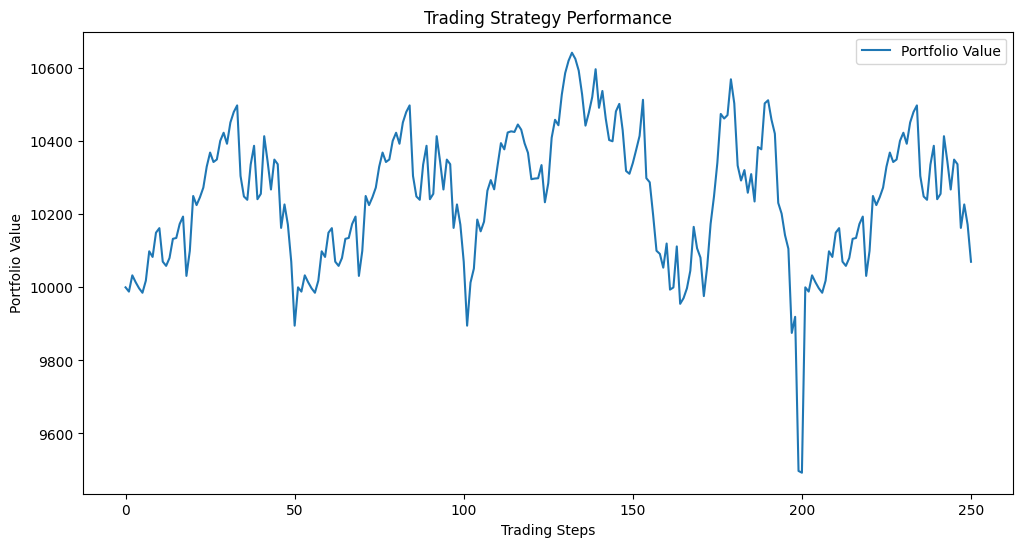

Final Portfolio Value: $10070.00
Total Return: 0.70%


In [ ]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
import ta  # Technical analysis library for feature engineering

class AdaptiveStockEnvironment(gym.Env):
    def __init__(self, data, initial_balance=10000, max_steps=250):
        super().__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.max_steps = max_steps
        self.balance = initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(10,),
            dtype=np.float32
        )

    def _get_observation(self):
        if self.current_step >= len(self.data):
            raise ValueError("Trading steps exceed available data")

        row = self.data.iloc[self.current_step]
        features = [
            row['Close'],
            row['Volume'],
            row['Return'],
            row['RSI'],
            row['MACD'],
            row['BBand_high'],
            row['BBand_low'],
            self.balance / self.initial_balance,
            self.shares_held,
            (self.balance + self.shares_held * row['Close']) / self.initial_balance
        ]

        return np.array(features, dtype=np.float32)

    def step(self, action):
        """
        Execute a trading step with sophisticated trading logic
        """
        action = np.clip(action, -1, 1)[0]

        current_price = self.data.iloc[self.current_step]['Close']
        trade_proportion = abs(action)
        trade_amount = int(trade_proportion * 100)

        if action > 0:  # Buy signal
            max_shares = int(self.balance / current_price)
            purchase_shares = min(trade_amount, max_shares)
            purchase_cost = purchase_shares * current_price

            if purchase_cost <= self.balance:
                self.shares_held += purchase_shares
                self.balance -= purchase_cost
        else:  # Sell signal
            sell_shares = min(trade_amount, self.shares_held)
            sell_value = sell_shares * current_price

            self.balance += sell_value
            self.shares_held -= sell_shares

        portfolio_value = self.balance + (self.shares_held * current_price)

        reward = (portfolio_value - self.initial_balance) / self.initial_balance

        self.current_step += 1
        done = self.current_step >= self.max_steps - 1

        return self._get_observation(), reward, done, {}

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        return self._get_observation()

    def get_date(self):
        return self.data.index[self.current_step] if len(self.data) > 0 else None

def prepare_data(csv_path):
    data = pd.read_csv(csv_path)
    column_map = {
        col: col.capitalize()
        for col in data.columns
    }
    data.rename(columns=column_map, inplace=True)
    required_columns = ['Close', 'Volume']
    for col in required_columns:
        if col not in data.columns:
            if col == 'Close' and 'Last' in data.columns:
                data['Close'] = data['Last']
            elif col == 'Volume':
                data['Volume'] = 1


    data['Return'] = data['Close'].pct_change().fillna(0)

    # Technical Indicators using TA library
    try:
        data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
        macd = ta.trend.MACD(data['Close'])
        data['MACD'] = macd.macd()
        bbands = ta.volatility.BollingerBands(data['Close'])
        data['BBand_high'] = bbands.bollinger_hband()
        data['BBand_low'] = bbands.bollinger_lband()
    except Exception as e:
        print(f"Technical indicator computation failed: {e}")
        data['RSI'] = 50
        data['MACD'] = 0
        data['BBand_high'] = data['Close'] * 1.1
        data['BBand_low'] = data['Close'] * 0.9


    data.fillna(method='ffill', inplace=True)
    data.fillna(0, inplace=True)

    return data

def train_trading_strategies(data):
    strategies = {
        "momentum": AdaptiveStockEnvironment(data),
        "value": AdaptiveStockEnvironment(data)
    }

    # Train sub-agents for each strategy
    sub_agents = {}
    for strategy_name, env in strategies.items():
        agent = SAC("MlpPolicy", env, verbose=0)
        agent.learn(total_timesteps=10000)
        sub_agents[strategy_name] = agent

    return strategies, sub_agents

def simulate_trading(strategies, sub_agents, initial_balance=10000):
    current_strategy = list(strategies.keys())[0]
    current_env = strategies[current_strategy]
    current_agent = sub_agents[current_strategy]

    observation = current_env.reset()
    net_worths = [initial_balance]
    strategy_history = [current_strategy]

    for step in range(current_env.max_steps):
        action = current_agent.predict(observation)[0]
        observation, reward, done, _ = current_env.step(action)
        if step % 50 == 0:  # Every 50 steps, consider switching
            if reward < 0:  # If current strategy is losing money
                # Switch to the other strategy
                current_strategy = "value" if current_strategy == "momentum" else "momentum"
                current_env = strategies[current_strategy]
                current_agent = sub_agents[current_strategy]

                # Reset the environment for the new strategy
                observation = current_env.reset()

        # Track portfolio value
        portfolio_value = current_env.balance + (current_env.shares_held * current_env.data.iloc[current_env.current_step]['Close'])
        net_worths.append(portfolio_value)
        strategy_history.append(current_strategy)

        if done:
            break

    return net_worths, strategy_history

def main():
    data = prepare_data('/content/volatilityDataset.csv')
    strategies, sub_agents = train_trading_strategies(data)
    net_worths, strategies_used = simulate_trading(strategies, sub_agents)
    plt.figure(figsize=(12, 6))
    plt.plot(net_worths, label='Portfolio Value')
    plt.title('Trading Strategy Performance')
    plt.xlabel('Trading Steps')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()
    print(f"Final Portfolio Value: ${net_worths[-1]:.2f}")
    print(f"Total Return: {((net_worths[-1] - net_worths[0])/net_worths[0]*100):.2f}%")

if __name__ == "__main__":
    main()